In [1]:
%load_ext autoreload
%autoreload 2
import cv2
from scipy.ndimage import distance_transform_edt as dist
import IPython.display 
import importlib
import skimage.io as imgio
import numpy as np
import os
import torch
import torch.nn.functional as F
import math
import re
from matplotlib import pyplot as plt
from scipy import ndimage
from topoloss4neurons.networks import UNet
import networktraining as nt
# from topoloss4neurons import load_dataset
%matplotlib inline
def imshow(img):
    _,ret = cv2.imencode('.jpg', img) 
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)
    
def showCube(vol):
    v1=np.max(vol,axis=0)
    v2=np.max(vol,axis=1)
    v3=np.max(vol,axis=2)
    imshow(v1*255)
    imshow(v2*255)
    imshow(v3*255) 

path_apls: /cvlabdata1/home/zakariya/SegmentingBrains


In [2]:
from tqdm import tqdm 

In [3]:
def volInds(swcCoords,scale,volDims,offset,downsampling):
    """
    For scaling and shifting coordinates
    """
    x=int((swcCoords[volDims[0]]*scale[0]+offset[0])*downsampling[0])
    y=int((swcCoords[volDims[1]]*scale[1]+offset[1])*downsampling[1])
    z=int((swcCoords[volDims[2]]*scale[2]+offset[2])*downsampling[2])
    return x,y,z

In [4]:
def traceLine(lbl,begPoint,endPoint):
    """
    Renders a line represented by two nodes
    """
    d=endPoint-begPoint
    s=begPoint
    mi=np.argmax(np.fabs(d))
    coef=d/d[mi]
    sz=np.array(lbl.shape)
    numsteps=int(abs(d[mi]))+1
    step=int(d[mi]/abs(d[mi]))
    for t in range(0,numsteps):
        pos=np.array(s+coef*t*step)
        if np.all(pos<sz) and np.all(pos>=0):
            #print(pos)
            lbl[tuple(pos.astype(np.int))]=1
#         else:
#             print("reqested point",pos,"but the volume size is",sz)
    return lbl


In [5]:
def readSWC(brain_i):
    """
    Returns the full annotation information for the given brain index
    """
    if brain_i == 6:
        swcfname = "/cvlabdata2/home/oner/CarlsData/AL066-AL_stamp_2019_07_23_10_34.ano.eswc"
    elif brain_i == 8:
        swcfname = "/cvlabdata2/home/oner/CarlsData/AL080_stamp_2020_01_22_13_26.ano.eswc"
    elif brain_i == 9:
        swcfname = "/cvlabdata2/home/oner/CarlsData /AL092_stamp_2020_01_09_11_10.ano.eswc_sorted.eswc"
    elif brain_i == 175:
        swcfname = "/cvlabdata2/home/oner/CarlsData/annotations/AL175_stamp_2021_02_10_13_52.ano.eswc"
    elif brain_i == 223:
        swcfname = None
        return {0:[6833,7549,488],1:[3091,7665,410],2:[7088,7804,554],3:[3346,7920,665]}
    elif brain_i == 230:
        swcfname = None
        return {0:[3935,8628,288],1:[4109,8883,543],2:[3713,8397,389],3:[3968,8653,644]}
    elif brain_i == 225:
        swcfname = None
        return {0:[3600,8400,600]}
    elif brain_i == 250:
        swcfname = None
        return {0:[3500,8700,400]}
    elif brain_i == 177:
        swcfname = None
        return {0:[2100,8200,1000]}
    elif brain_i == 244:
        swcfname = None
        return {0:[3000,9000,600]}
    else:
        return
    nodes=dict()
    for a in open(swcfname):
        if (re.match('\s*\#',a)!=None):
#             print("commment line", a)
            continue
        b=a.split()
        c=map(lambda x: float(x), b)
        d=list(c)
        nodes[int(d[0])]=d
    return nodes

def getCoords(brain_i):
    """
    Returns the location of nodes in the annotations
    """
    nodes = readSWC(brain_i)
    coords = []
    for k in nodes :
        n=nodes[k]
        if brain_i == 6:
            x,y,z= volInds(n,[1,1,1],[2,3,4], [0,0,0], [1,1,1])
        elif brain_i == 8:
            x,y,z= volInds(n,[1,1,1],[2,3,4], [0,0,0], [1,1,1])
        elif brain_i == 9:
            x,y,z= volInds(n,[1,1,1],[2,3,4], [0,0,0], [1,1,1])
        elif brain_i == 175:
            x,y,z= volInds(n,[1,1,1],[2,3,4], [0,0,0], [1,1,1])
        elif brain_i == 223:
            x,y,z= volInds(n,[1,1,1],[0,1,2], [0,0,0], [1,1,1])
        elif brain_i == 230:
            x,y,z= volInds(n,[1,1,1],[0,1,2], [0,0,0], [1,1,1])
        elif brain_i == 225:
            x,y,z= volInds(n,[1,1,1],[0,1,2], [0,0,0], [1,1,1])
        elif brain_i == 250:
            x,y,z= volInds(n,[1,1,1],[0,1,2], [0,0,0], [1,1,1])
        elif brain_i == 177:
            x,y,z= volInds(n,[1,1,1],[0,1,2], [0,0,0], [1,1,1])
        elif brain_i == 244:
            x,y,z= volInds(n,[1,1,1],[0,1,2], [0,0,0], [1,1,1])
        coords.append([x,y,z])
    return coords

def renderSWC2volume(swcfname, volumeDims, volCL, scale, offset, downsampling):
    '''
      swcfname      name of the swc file
      volumeDims    one-dimensional array;
                    volumeDims[1] is index of volCL dimension corresponding to X
                    volumeDims[2] is index of volCL dimension corresp to Y
                    volumeDims[3] is index of volCL dimension corresp to Z
                    X,Y,Z are as interpreted in the CWS format
      volCL         np array into which we will render ground truth centerlines
    '''
    distthresh=40
    nodes=dict()
    for a in open(swcfname):
        if (re.match('\s*\#',a)!=None):
#             print("commment line", a)
            continue
        b=a.split()
        c=map(lambda x: float(x), b)
        d=list(c)
        nodes[int(d[0])]=d
        #print(d)
    # start here
    for k in nodes :
        n=nodes[k]
        x,y,z= volInds(n,scale,volumeDims, offset, downsampling)
        parent=nodes.get(int(n[6]),None)
        #print(n)
        if parent!=None :
            #print(n,parent)
            xp,yp,zp=volInds(parent,scale,volumeDims, offset, downsampling)
            #print(x,y,z,volCL.shape)
            #print(xp,yp,zp,volCL.shape)
            if (x!=xp or y!=yp or z!=zp) and ((abs(x-xp)+abs(y-yp)+abs(z-zp))<distthresh):
                #print("line: ({},{},{})-({},{},{})".format(xp,yp,zp,x,y,z))
                traceLine(volCL,np.array([xp,yp,zp]),np.array([x,y,z]))
        

In [6]:
def getCubeCoords(brain_i):
    """
    Returns xyz borders of the cubes according to terafiles
    """
    if brain_i == 6:
        direc = "/cvlabdata2/home/oner/CarlsData/6RES(11711x16382x2000)/"
    elif brain_i == 8:
        direc = "/cvlabdata2/home/oner/CarlsData/8RES(11692x19566x1600)/"
    elif brain_i == 9:
        direc = "/cvlabdata2/home/oner/CarlsData/9RES(11692x16123x1700)/"
    elif brain_i == 175:
        direc = "/cvlabdata2/home/oner/CarlsData/AL175/RES(15186x17117x1919)"
    elif brain_i == 223:
        direc = "/cvlabdata2/home/oner/CarlsData/Data/AL223/"
    elif brain_i == 230:
        direc = "/home/oner/samba/TeraConvertion/AL230/RES(14504x17408x2468)/"
    elif brain_i == 225:
        direc = "/home/oner/samba/TeraConvertion/AL225_tera/RES(16656x17408x2235)"
    elif brain_i == 250:
        direc = "/home/oner/samba/TeraConvertion/AL250_tera/RES(14680x17258x2068)"
    elif brain_i == 177:
        direc = "/home/oner/samba/TeraConvertion/AL177_tera/RES(16214x17088x2335)"
    elif brain_i == 244:
        direc = "/home/oner/samba/TeraConvertion/AL244_tera/RES(14680x16385x1998)"
    elif brain_i == 261:
        direc = "/home/oner/samba/TeraConvertion/AL261/RES(16727x18258x2168)"
    else:
        return
    yind = sorted([int(x)//10 for x in os.listdir(direc) if x.startswith("0") or x.startswith("1")] )
    xind = sorted([int(x.split("_")[-1])//10 for x in os.listdir(os.path.join(direc,"000000")) if x.startswith("0") or x.startswith("1")] )
    zind = sorted([int(x.split("_")[-1][:-4])//10 for x in os.listdir(os.path.join(direc,"000000", "000000_000000")) if x.startswith("0") or x.startswith("1")] )
    
    return xind, yind, zind

In [7]:
import os
import tifffile
def getCube(brain_i, cube):
    """
    Returns the image of the desired cube in the desired brain
    """
    if brain_i == 6:
        direc = "/home/oner/samba/Ter/6RES(11711x16382x2000)/"
    elif brain_i == 8:
        direc = "/cvlabdata2/home/oner/CarlsData/8RES(11692x19566x1600)/"
    elif brain_i == 9:
        direc = "/cvlabdata2/home/oner/CarlsData/9RES(11692x16123x1700)/"
    elif brain_i == 175:
        direc = "/cvlabdata2/home/oner/CarlsData/AL175/RES(15186x17117x1919)"
    elif brain_i == 223:
        direc = "/cvlabdata2/home/oner/CarlsData/Data/AL223/"
    elif brain_i == 230:
        direc = "/home/oner/samba/TeraConvertion/AL230/RES(14504x17408x2468)/"
    elif brain_i == 225:
        direc = "/home/oner/samba/TeraConvertion/AL225_tera/RES(16656x17408x2235)"
    elif brain_i == 250:
        direc = "/home/oner/samba/TeraConvertion/AL250_tera/RES(14680x17258x2068)"
    elif brain_i == 177:
        direc = "/home/oner/samba/TeraConvertion/AL177_tera/RES(16214x17088x2335)"
    elif brain_i == 244:
        direc = "/home/oner/samba/TeraConvertion/AL244_tera/RES(14680x16385x1998)"
    elif brain_i == 261:
        direc = "/home/oner/samba/TeraConvertion/AL261/RES(16727x18258x2168)"
    else:
        return
    xs,ys,zs = getCubeCoords(brain_i)
    x,y,z = cube
    l1 = "{:06d}".format(ys[y]*10)
    l2 = "{:06d}_{:06d}".format(ys[y]*10,xs[x]*10)
    l3 = "{:06d}_{:06d}_{:06d}.tif".format(ys[y]*10,xs[x]*10,zs[z]*10)
    volume = tifffile.imread(os.path.join(direc,l1,l2,l3))
    return volume.transpose((1,2,0))

def getCubename(brain_i, cube):
    """
    Returns the directory for the desired cube
    """
    if brain_i == 6:
        direc = "/cvlabdata2/home/oner/CarlsData/6RES(11711x16382x2000)/"
    elif brain_i == 8:
        direc = "/cvlabdata2/home/oner/CarlsData/8RES(11692x19566x1600)/"
    elif brain_i == 9:
        direc = "/cvlabdata2/home/oner/CarlsData/9RES(11692x16123x1700)/"
    elif brain_i == 175:
        direc = "/cvlabdata2/home/oner/CarlsData/AL175/RES(15186x17117x1919)"
    elif brain_i == 223:
        direc = "/cvlabdata2/home/oner/CarlsData/Data/AL223/"
    elif brain_i == 230:
        direc = "/home/oner/samba/TeraConvertion/AL230/RES(14504x17408x2468)/"
    elif brain_i == 225:
        direc = "/home/oner/samba/TeraConvertion/AL225_tera/RES(16656x17408x2235)"
    elif brain_i == 250:
        direc = "/home/oner/samba/TeraConvertion/AL250_tera/RES(14680x17258x2068)"
    elif brain_i == 177:
        direc = "/home/oner/samba/TeraConvertion/AL177_tera/RES(16214x17088x2335)"
    elif brain_i == 244:
        direc = "/home/oner/samba/TeraConvertion/AL244_tera/RES(14680x16385x1998)"
    elif brain_i == 261:
        direc = "/home/oner/samba/TeraConvertion/AL261/RES(16727x18258x2168)"
    else:
        return
    xs,ys,zs = getCubeCoords(brain_i)
    x,y,z = cube
    l1 = "{:06d}".format(ys[y]*10)
    l2 = "{:06d}_{:06d}".format(ys[y]*10,xs[x]*10)
    l3 = "{:06d}_{:06d}_{:06d}.tif".format(ys[y]*10,xs[x]*10,zs[z]*10)
    
    return os.path.join("/datasets/" + direc.split("/")[-2],l1,l2,l3)

def getLabel(brain_i,cube):
    """
    Returns the label of the desired cube in the desired brain
    """
    xs, ys, zs = getCubeCoords(brain_i)
    xi, xf = xs[cube[0]:cube[0]+2]
    yi, yf = ys[cube[1]:cube[1]+2]
    zi, zf = zs[cube[2]:cube[2]+2]
    m=[1,1,1]
    o=[-int(yi),-int(xi),-int(zi)]
    scale_factor=[1,1,1]

    downsampling=torch.tensor(scale_factor,dtype=torch.double)
    offset=torch.tensor(o,dtype=torch.double)
    scale=torch.tensor(m,dtype=torch.double)
    volDims=torch.tensor([3,2,4],dtype=torch.long)
    vols = np.zeros((yf-yi,xf-xi,zf-zi), dtype=np.uint8)
    if brain_i == 6:
        renderSWC2volume(swcname1, volDims, vols, scale, offset, downsampling)
    elif brain_i == 8:
        renderSWC2volume(swcname2, volDims, vols, scale, offset, downsampling)
    elif brain_i == 9:
        renderSWC2volume(swcname3, volDims, vols, scale, offset, downsampling)
    elif brain_i == 175:
        renderSWC2volume(swcname4, volDims, vols, scale, offset, downsampling)
    else:
        return
    return vols

In [8]:
def findCubes(brain_i):
    """
    If the annotation is provided, returns the indices of cubes which contains annotated pixels
    """
    xs, ys, zs = getCubeCoords(brain_i)
    coords = getCoords(brain_i)
    cubes = []
    if len(coords) == 0:
        cubes = np.array(np.meshgrid(np.arange(len(xs)),np.arange(len(ys)),np.arange(len(zs)))).T.reshape((-1,3))
    for c in coords:
        xi = np.where(c[0] > np.array(xs))[0][-1]
        yi = np.where(c[1] > np.array(ys))[0][-1]
        zi = np.where(c[2] > np.array(zs))[0][-1]
        if [xi,yi,zi] not in cubes:
            cubes.append([xi,yi,zi])
    return cubes

In [9]:
##### hasnt been modified yet ######

In [10]:
def loadTahaPred(brain_i, cube):
    """
    Returns the prediction of the desired cube in the desired brain
    """
    if brain_i == 6:
        direc = "/cvlabdata2/home/oner/CarlsData/6RES(11711x16382x2000)/"
    elif brain_i == 8:
        direc = "/cvlabdata2/home/oner/CarlsData/8RES(11692x19566x1600)/"
    elif brain_i == 9:
        direc = "/cvlabdata2/home/oner/CarlsData/9RES(11692x16123x1700)/"
    elif brain_i == 175:
        direc = "/cvlabdata2/home/oner/CarlsData/AL175/RES(15186x17117x1919)/"
    elif brain_i == 223:
        direc = "/cvlabdata2/home/oner/CarlsData/Data/AL223/"
    elif brain_i == 230:
        direc = "/cvlabdata2/home/oner/CarlsData/Data/AL230/"
    elif brain_i == 225:
        direc = "/cvlabdata2/home/zakariya/CarlsData/other_Brains_Preds/AL225"
    elif brain_i == 250:
        direc = "/cvlabdata2/home/zakariya/CarlsData/other_Brains_Preds/AL250"
    elif brain_i == 177:
        direc = "/cvlabdata2/home/zakariya/CarlsData/other_Brains_Preds/AL177"
    elif brain_i == 244:
        direc = "/cvlabdata1/home/zakariya/CarlsData/AL244"
    elif brain_i == 261:
        direc = "/cvlabdata1/home/zakariya/CarlsData/AL261"
        
    else:
        return
    xs,ys,zs = getCubeCoords(brain_i)
    x,y,z = cube
    l1 = "{:06d}".format(ys[y]*10)
    l2 = "{:06d}_{:06d}".format(ys[y]*10,xs[x]*10)
    l3 = "{:06d}_{:06d}_{:06d}.npy".format(ys[y]*10,xs[x]*10,zs[z]*10)
    pred = np.load(os.path.join(direc,l1,l2,l3)).transpose(2,0,1)
    return pred

def saveTahaPred(brain_i, cube, pred):
    """
    Saves the prediction for the desired cub in the desired brain
    """
    if brain_i == 6:
        direc = "/cvlabdata2/home/oner/CarlsData/6RES(11711x16382x2000)/"
    elif brain_i == 8:
        direc = "/cvlabdata2/home/oner/CarlsData/8RES(11692x19566x1600)/"
    elif brain_i == 9:
        direc = "/cvlabdata2/home/oner/CarlsData/9RES(11692x16123x1700)/"
    elif brain_i == 175:
        direc = "/cvlabdata2/home/oner/CarlsData/AL175/RES(15186x17117x1919)/"
    elif brain_i == 223:
        direc = "/cvlabdata2/home/oner/CarlsData/Data/AL223/"
    elif brain_i == 230:
        direc = "/cvlabdata2/home/oner/CarlsData/Data/AL230/"
    elif brain_i == 225:
        direc = "/cvlabdata2/home/zakariya/CarlsData/other_Brains_Preds/AL225"
    elif brain_i == 250:
        direc = "/cvlabdata2/home/zakariya/CarlsData/other_Brains_Preds/AL250"
    elif brain_i == 177:
        direc = "/cvlabdata2/home/zakariya/CarlsData/other_Brains_Preds/AL177"
    elif brain_i == 244:
        direc = "/cvlabdata1/home/zakariya/CarlsData/AL244"
    elif brain_i == 261:
        direc = "/cvlabdata1/home/zakariya/CarlsData/AL261"
        
    else:
        return
    xs,ys,zs = getCubeCoords(brain_i)
    x,y,z = cube
    l1 = "{:06d}".format(ys[y]*10)
    l2 = "{:06d}_{:06d}".format(ys[y]*10,xs[x]*10)
    l3 = "{:06d}_{:06d}_{:06d}.npy".format(ys[y]*10,xs[x]*10,zs[z]*10)
    nt.utils.mkdir(os.path.join(direc,l1,l2))
    np.save(os.path.join(direc,l1,l2,l3), pred.transpose(1,2,0))

In [11]:
def loadPred(brain_i, cube):
    """
    Returns the prediction of the desired cube in the desired brain
    """
    if brain_i == 6:
        direc = "/cvlabdata2/home/oner/CarlsData/6RES(11711x16382x2000)/"
    elif brain_i == 8:
        direc = "/cvlabdata2/home/oner/CarlsData/8RES(11692x19566x1600)/"
    elif brain_i == 9:
        direc = "/cvlabdata2/home/oner/CarlsData/9RES(11692x16123x1700)/"
    elif brain_i == 175:
        direc = "/cvlabdata2/home/oner/CarlsData/AL175/RES(15186x17117x1919)/"
    elif brain_i == 223:
        direc = "/cvlabdata2/home/oner/CarlsData/Data/AL223/"
    elif brain_i == 230:
        direc = "/cvlabdata2/home/oner/CarlsData/Data/AL230/"
    # no 225 pred yet
    else:
        return
    xs,ys,zs = getCubeCoords(brain_i)
    x,y,z = cube
    l1 = "{:06d}".format(ys[y]*10)
    l2 = "{:06d}_{:06d}".format(ys[y]*10,xs[x]*10)
    l3 = "{:06d}_{:06d}_{:06d}.npy".format(ys[y]*10,xs[x]*10,zs[z]*10)
    pred = np.load(os.path.join(direc,l1,l2,l3)).transpose(2,0,1)
    return pred

def loadPredf(brain_i, cube):
    """
    Returns the prediction_f of the desired cub in the desired brain
    """
    if brain_i == 6:
        direc = "/cvlabdata2/home/oner/CarlsData/6RES(11711x16382x2000)/"
    elif brain_i == 8:
        direc = "/cvlabdata2/home/oner/CarlsData/8RES(11692x19566x1600)/"
    elif brain_i == 9:
        direc = "/cvlabdata2/home/oner/CarlsData/9RES(11692x16123x1700)/"
    elif brain_i == 175:
        direc = "/cvlabdata2/home/oner/CarlsData/AL175/RES(15186x17117x1919)/"
    elif brain_i == 223:
        direc = "/cvlabdata2/home/oner/CarlsData/Data/AL223/"
    elif brain_i == 230:
        direc = "/cvlabdata2/home/oner/CarlsData/Data/AL230/"
    else:
        return
    xs,ys,zs = getCubeCoords(brain_i)
    x,y,z = cube
    l1 = "{:06d}".format(ys[y]*10)
    l2 = "{:06d}_{:06d}".format(ys[y]*10,xs[x]*10)
    l3 = "{:06d}_{:06d}_{:06d}_f.npy".format(ys[y]*10,xs[x]*10,zs[z]*10)
    pred = np.load(os.path.join(direc,l1,l2,l3)).transpose(2,0,1)
    return pred

def savePred(brain_i, cube, pred):
    """
    Saves the prediction for the desired cub in the desired brain
    """
    if brain_i == 6:
        direc = "/cvlabdata2/home/oner/CarlsData/6RES(11711x16382x2000)/"
    elif brain_i == 8:
        direc = "/cvlabdata2/home/oner/CarlsData/8RES(11692x19566x1600)/"
    elif brain_i == 9:
        direc = "/cvlabdata2/home/oner/CarlsData/9RES(11692x16123x1700)/"
    elif brain_i == 175:
        direc = "/cvlabdata2/home/oner/CarlsData/AL175/RES(15186x17117x1919)/"
    elif brain_i == 223:
        direc = "/cvlabdata2/home/oner/CarlsData/Data/AL223/"
    elif brain_i == 230:
        direc = "/cvlabdata2/home/oner/CarlsData/Data/AL230/"
    
    else:
        return
    xs,ys,zs = getCubeCoords(brain_i)
    x,y,z = cube
    l1 = "{:06d}".format(ys[y]*10)
    l2 = "{:06d}_{:06d}".format(ys[y]*10,xs[x]*10)
    l3 = "{:06d}_{:06d}_{:06d}.npy".format(ys[y]*10,xs[x]*10,zs[z]*10)
    nt.utils.mkdir(os.path.join(direc,l1,l2))
    np.save(os.path.join(direc,l1,l2,l3), pred.transpose(1,2,0))
    
def savePredf(brain_i, cube, pred):
    """
    Saves the prediction_f for the desired cub in the desired brain
    """
    if brain_i == 6:
        direc = "/cvlabdata2/home/oner/CarlsData/6RES(11711x16382x2000)/"
    elif brain_i == 8:
        direc = "/cvlabdata2/home/oner/CarlsData/8RES(11692x19566x1600)/"
    elif brain_i == 9:
        direc = "/cvlabdata2/home/oner/CarlsData/9RES(11692x16123x1700)/"
    elif brain_i == 175:
        direc = "/cvlabdata2/home/oner/CarlsData/AL175/RES(15186x17117x1919)/"
    elif brain_i == 223:
        direc = "/cvlabdata2/home/oner/CarlsData/Data/AL223/"
    elif brain_i == 230:
        direc = "/cvlabdata2/home/oner/CarlsData/Data/AL230/"
    else:
        return
    xs,ys,zs = getCubeCoords(brain_i)
    x,y,z = cube
    l1 = "{:06d}".format(ys[y]*10)
    l2 = "{:06d}_{:06d}".format(ys[y]*10,xs[x]*10)
    l3 = "{:06d}_{:06d}_{:06d}_f.npy".format(ys[y]*10,xs[x]*10,zs[z]*10)
    nt.utils.mkdir(os.path.join(direc,l1,l2))
    np.save(os.path.join(direc,l1,l2,l3), pred.transpose(1,2,0))

In [12]:
# swcname="/cvlabdata2/home/kozinski/MBFneuron/DeFelipe_Auto_DK_Edited_Complete.SWC"
swcname1 = "/cvlabdata2/home/oner/CarlsData/AL066-AL_stamp_2019_07_23_10_34.ano.eswc"
swcname2 = "/cvlabdata2/home/oner/CarlsData/AL080_stamp_2020_01_22_13_26.ano.eswc"
swcname3 = "/cvlabdata2/home/oner/CarlsData/AL092_stamp_2020_01_09_11_10.ano.eswc_sorted.eswc"
swcname4 = "/cvlabdata2/home/oner/CarlsData/AL175_stamp_2021_02_10_13_52.ano.eswc"

In [13]:
brain_i = 244

In [14]:
nodes = readSWC(brain_i)
coords = getCoords(brain_i)

In [15]:
xs,ys,zs = getCubeCoords(brain_i)

In [16]:
cubes = findCubes(brain_i)

In [20]:
def getNeighbours(cube_i, which_n=[], is_all=False):
    """
    Returns the indices of neighbour cubes of the desired cube
    which_n : If you want to specify which neighbours you want to get
    """
    neighs = []
    if is_all:
        for i in range(6):
            n = [0,0,0]
            if i < 3:
                n[i] = 1
            else:
                n[i%3] = -1
            neighs.append(list(np.array(cube_i) + np.array(n)))
    else:
        for n in which_n:
            neighs.append(list(np.array(cube_i) + np.array(n)))
        return neighs
    
    return neighs

def checkBorders(pred, th=3, border=5):
    """
    For the given prediction check which borders of the cube contains foreground voxels
    th : Threshold to binarize the prediction
    border : width of border region you want to check for foreground voxels
    """
    borders = []
    pred_bin = pred < th
    if np.sum(pred_bin[:border,:,:]) > 0:
        borders.append([0,-1,0])
    if np.sum(pred_bin[:,:border,:]) > 0:
        borders.append([-1,0,0])
    if np.sum(pred_bin[:,:,:border]) > 0:
        borders.append([0,0,-1])
    if np.sum(pred_bin[-border:,:,:]) > 0:
        borders.append([0,1,0])
    if np.sum(pred_bin[:,-border:,:]) > 0:
        borders.append([1,0,0])
    if np.sum(pred_bin[:,:,-border:]) > 0:
        borders.append([0,0,1])
    return borders

def process_chunk(chunk):
    pred = network(chunk)
    return pred

def segmentCube(im, network):
    """
    Segments the given image with the given network
    """
    with nt.torch_no_grad:
        image_i = np.float32(im[None,None])
        image_i  = nt.to_torch(image_i, volatile=True).contiguous().to("cuda")
        out_shape = (image_i.shape[0],1,*image_i.shape[2:])
        pred_i = nt.to_torch(np.empty(out_shape, np.float32), volatile=True).cuda()
        pred_i = nt.process_in_chuncks(image_i, pred_i, process_chunk,
                                       [96,96,96], [12,12,12])
        pred_np = pred_i.detach().cpu().numpy()[0,0]
        return pred_np

In [21]:
network = UNet(in_channels=1,
                   m_channels=32,
                   out_channels=1,
                   n_convs=2,
                   n_levels=5,
                   dropout=0.1,
                   batch_norm=True,
                   upsampling="deconv",
                   pooling="max",
                   three_dimensional=True).to("cuda")

network.load_state_dict(torch.load("/cvlabdata2/home/oner/CarlsData/new_logs/log_base_5lvl_2convs/network_bestqual.pickle"))
network.eval()

UNet(
  (down_path): Sequential(
    (0): DownBlock(
      (layers): Sequential(
        (0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (4): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): Dropout3d(p=0.1, inplace=False)
      )
    )
    (1): DownBlock(
      (layers): Sequential(
        (0): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): ReLU(inplace=True)
        (4): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)

In [22]:
import time
ttt = time.time()
save = True
# Keeps track of the already segmented cubes so that we don't segment them again
processed_cubes = []
# Cubes in queue for segmenting
pending_cubes = []

## Select random starting cubes
starting_cubes = np.random.choice(len(cubes),1,replace=False)
starting_cubes = [cubes[i] for i in starting_cubes]
# Add all given statring cubes to the queue
for sc in starting_cubes:
    pending_cubes.append(sc)
ii = 0
# Get the coordinates of the cube (jsut for printing)
xs,ys,zs = getCubeCoords(brain_i)

while len(pending_cubes) > 0: # checks if there are any cubes in queue
    current_cube = pending_cubes.pop(0) # get the first cube in queue
    if current_cube in processed_cubes: # check if you already processed this cube
        print(current_cube, " already processed")
        continue
    print("Processing ", current_cube)
    print(xs[current_cube[0]],ys[current_cube[1]],zs[current_cube[2]])
    
    im = getCube(brain_i, current_cube)/65535 # get the image of the cube and normalize the uint16 images
    pred = segmentCube(im, network) # get the prediction

    if save:
        saveTahaPred(brain_i, current_cube, pred) # save them if you want
    which_n = checkBorders(pred, th=8, border=8) # check for border voxels and find the neighbours which probably contains neuron
    
    print("Neighbours ", getNeighbours(current_cube, which_n))
    processed_cubes.append(current_cube)
    pending_cubes += getNeighbours(current_cube, which_n) # add the neighbour according to border voxels
    
    if ii % 20:
        plt.figure(figsize=(20,10))
        plt.subplot(121)
        plt.imshow(im.max(2))
        plt.subplot(122)
        plt.imshow(pred.min(2))
        plt.show()
        
print(time.time()-ttt)


Processing  [11, 35, 2]
2777 8861 500
Neighbours  [[10, 35, 2], [11, 36, 2], [12, 35, 2]]
Processing  [10, 35, 2]
2525 8861 500
Neighbours  [[10, 34, 2], [9, 35, 2], [10, 35, 1], [10, 36, 2], [11, 35, 2]]
Processing  [11, 36, 2]
2777 9114 500
Neighbours  [[10, 36, 2]]
Processing  [12, 35, 2]
3029 8861 500
Neighbours  [[13, 35, 2]]
Processing  [10, 34, 2]
2525 8608 500
Neighbours  [[9, 34, 2], [10, 35, 2]]
Processing  [9, 35, 2]
2273 8861 500
Neighbours  [[9, 34, 2], [9, 35, 1], [10, 35, 2]]
Processing  [10, 35, 1]
2525 8861 250
Neighbours  [[10, 34, 1], [9, 35, 1], [10, 36, 1], [11, 35, 1], [10, 35, 2]]
Processing  [10, 36, 2]
2525 9114 500
Neighbours  [[10, 35, 2], [9, 36, 2], [10, 36, 1], [11, 36, 2]]
[11, 35, 2]  already processed
[10, 36, 2]  already processed
Processing  [13, 35, 2]
3281 8861 500
Neighbours  [[12, 35, 2], [14, 35, 2]]
Processing  [9, 34, 2]
2273 8608 500
Neighbours  [[8, 34, 2], [10, 34, 2]]
[10, 35, 2]  already processed
[9, 34, 2]  already processed
Processing  

Neighbours  []
[12, 38, 1]  already processed
Processing  [13, 37, 1]
3281 9367 250
Neighbours  [[13, 36, 1], [12, 37, 1], [13, 38, 1], [14, 37, 1]]
[12, 35, 0]  already processed
[11, 36, 0]  already processed
Processing  [13, 36, 0]
3281 9114 0
Neighbours  [[13, 35, 0], [12, 36, 0], [14, 36, 0], [13, 36, 1]]
[12, 36, 1]  already processed
[13, 35, 1]  already processed
[12, 36, 1]  already processed
[13, 36, 0]  already processed
[13, 37, 1]  already processed
Processing  [14, 36, 1]
3533 9114 250
Neighbours  [[14, 35, 1], [13, 36, 1]]
Processing  [11, 31, 1]
2777 7849 250
Neighbours  [[11, 32, 1]]
[11, 33, 1]  already processed
Processing  [12, 32, 1]
3029 8102 250
Neighbours  [[12, 31, 1], [12, 32, 0], [12, 33, 1], [13, 32, 1]]
[11, 33, 1]  already processed
Processing  [12, 33, 0]
3029 8355 0
Neighbours  []
[12, 34, 1]  already processed
Processing  [13, 33, 1]
3281 8355 250
Neighbours  [[13, 32, 1], [12, 33, 1], [13, 33, 0]]
Processing  [12, 33, 2]
3029 8355 500
Neighbours  [[12,

Neighbours  [[9, 42, 1]]
[10, 42, 1]  already processed
Processing  [12, 28, 1]
3029 7090 250
Neighbours  [[13, 28, 1]]
[13, 29, 1]  already processed
Processing  [19, 36, 0]
4793 9114 0
Neighbours  [[19, 37, 0], [20, 36, 0]]
[18, 37, 0]  already processed
Processing  [19, 38, 0]
4793 9620 0
Neighbours  [[20, 38, 0]]
Processing  [20, 37, 0]
5045 9367 0
Neighbours  []
Processing  [19, 37, 1]
4793 9367 250
Neighbours  []
[9, 42, 1]  already processed
[13, 28, 1]  already processed
[19, 37, 0]  already processed
Processing  [20, 36, 0]
5045 9114 0
Neighbours  [[19, 36, 0], [21, 36, 0]]
Processing  [20, 38, 0]
5045 9620 0
Neighbours  []
[19, 36, 0]  already processed
Processing  [21, 36, 0]
5297 9114 0
Neighbours  [[21, 35, 0], [20, 36, 0], [21, 37, 0]]
Processing  [21, 35, 0]
5297 8861 0
Neighbours  [[21, 36, 0], [22, 35, 0]]
[20, 36, 0]  already processed
Processing  [21, 37, 0]
5297 9367 0
Neighbours  []
[21, 36, 0]  already processed
Processing  [22, 35, 0]
5549 8861 0
Neighbours  [[22

In [23]:
1

1

## For Visualizing the big predictions

In [24]:
import skimage.measure

# im2 = skimage.measure.block_reduce(im, (4,4,4), np.max)
# pred2 = skimage.measure.block_reduce(pred, (4,4,4), np.min, cval=15)

In [25]:
### Select the cubes and display them

In [26]:
neuron_cubes = []
for i in range(np.min(cubes,axis=0)[0], np.max(cubes,axis=0)[0]+1):
    for j in range(np.min(cubes,axis=0)[1], np.max(cubes,axis=0)[1]+1):
        for k in range(np.min(cubes,axis=0)[2], np.max(cubes,axis=0)[2]+1):
            neuron_cubes.append([i,j,k])

In [27]:
print(np.array(processed_cubes).max(0) - np.array(processed_cubes).min(0) +1)

[18 16  3]


In [28]:
dims = np.array(processed_cubes).max(0) - np.array(processed_cubes).min(0) +1
maxs = np.array(processed_cubes).max(0)
mins = np.array(processed_cubes).min(0)

In [29]:
## Downscale the cubes by 4 and concat them in an array to visualize it
## We are loading all the cubes in a big rectangle prism which contains the whole neuron
ims = np.zeros((dims[2]*75,dims[0]*75,dims[1]*75))
preds = 15*np.ones((dims[2]*75,dims[0]*75,dims[1]*75))
imss = []
predss = []
x = 0
y = 0
z = 0
ind = 0
for i in tqdm(range(mins[0],maxs[0]+1)):
    for j in range(mins[1],maxs[1]+1):
        for k in range(mins[2],maxs[2]+1):
            print(i,j,k)
            im = np.float32(getCube(brain_i, [i,j,k])/65535)
            im2 = skimage.measure.block_reduce(im, (4,4,4), np.max)
            try: # if it is segmented load the prediction
                pred_np = loadTahaPred(brain_i, [i,j,k])
                pred_np = skimage.measure.block_reduce(pred_np, (4,4,4), np.min, cval=15)
                print("Loaded")
            except: # if it is an empty cube just put all 15 (because the highest value in distance map is 15)
                pred_np = 15*np.ones(im2.shape)

            imss.append(im2)
            predss.append(pred_np)
            shp = im2.shape
            ims[z:z+shp[2],x:x+shp[1],y:y+shp[0]] = im2.transpose(2,1,0)
            preds[z:z+shp[2],x:x+shp[1],y:y+shp[0]] = pred_np.transpose(2,1,0)
            z += shp[2]
        y += shp[0]
        z = 0
    x += shp[1]
    y = 0

  0%|                                                    | 0/18 [00:00<?, ?it/s]

6 28 0
6 28 1
6 28 2
6 29 0
6 29 1
6 29 2
6 30 0
6 30 1
6 30 2
6 31 0
6 31 1
6 31 2
6 32 0
6 32 1
6 32 2
6 33 0
6 33 1
6 33 2
6 34 0
6 34 1
6 34 2
6 35 0
6 35 1
Loaded
6 35 2
6 36 0
6 36 1
6 36 2
6 37 0
6 37 1
6 37 2
6 38 0
6 38 1
6 38 2
6 39 0
6 39 1
6 39 2
6 40 0
6 40 1
6 40 2
6 41 0
6 41 1
6 41 2
6 42 0
6 42 1
6 42 2
6 43 0
6 43 1
6 43 2


  6%|██▍                                        | 1/18 [01:50<31:26, 110.98s/it]

7 28 0
7 28 1
7 28 2
7 29 0
7 29 1
7 29 2
7 30 0
7 30 1
7 30 2
7 31 0
7 31 1
7 31 2
7 32 0
7 32 1
7 32 2
7 33 0
7 33 1
7 33 2
7 34 0
7 34 1
Loaded
7 34 2
Loaded
7 35 0
7 35 1
Loaded
7 35 2
Loaded
7 36 0
7 36 1
7 36 2
7 37 0
7 37 1
7 37 2
7 38 0
7 38 1
7 38 2
Loaded
7 39 0
7 39 1
7 39 2
7 40 0
7 40 1
7 40 2
7 41 0
7 41 1
7 41 2
7 42 0
7 42 1
7 42 2
7 43 0
7 43 1
7 43 2


 11%|████▊                                      | 2/18 [03:41<29:34, 110.90s/it]

8 28 0
8 28 1
8 28 2
8 29 0
8 29 1
8 29 2
8 30 0
8 30 1
8 30 2
8 31 0
8 31 1
8 31 2
8 32 0
8 32 1
8 32 2
8 33 0
8 33 1
8 33 2
Loaded
8 34 0
8 34 1
8 34 2
Loaded
8 35 0
8 35 1
Loaded
8 35 2
Loaded
8 36 0
8 36 1
8 36 2
Loaded
8 37 0
8 37 1
Loaded
8 37 2
Loaded
8 38 0
8 38 1
Loaded
8 38 2
Loaded
8 39 0
8 39 1
8 39 2
8 40 0
8 40 1
8 40 2
8 41 0
8 41 1
8 41 2
8 42 0
8 42 1
8 42 2
8 43 0
8 43 1
8 43 2


 17%|███████▏                                   | 3/18 [05:39<28:15, 113.06s/it]

9 28 0
9 28 1
9 28 2
9 29 0
9 29 1
9 29 2
9 30 0
9 30 1
9 30 2
9 31 0
9 31 1
9 31 2
9 32 0
9 32 1
9 32 2
9 33 0
9 33 1
Loaded
9 33 2
9 34 0
9 34 1
Loaded
9 34 2
Loaded
9 35 0
9 35 1
Loaded
9 35 2
Loaded
9 36 0
9 36 1
Loaded
9 36 2
Loaded
9 37 0
9 37 1
Loaded
9 37 2
Loaded
9 38 0
9 38 1
Loaded
9 38 2
Loaded
9 39 0
9 39 1
9 39 2
9 40 0
9 40 1
9 40 2
9 41 0
9 41 1
9 41 2
9 42 0
9 42 1
Loaded
9 42 2
9 43 0
9 43 1
Loaded
9 43 2


 22%|█████████▌                                 | 4/18 [07:44<27:10, 116.43s/it]

10 28 0
10 28 1
10 28 2
10 29 0
10 29 1
10 29 2
10 30 0
10 30 1
10 30 2
10 31 0
10 31 1
10 31 2
10 32 0
10 32 1
10 32 2
10 33 0
10 33 1
10 33 2
10 34 0
10 34 1
Loaded
10 34 2
Loaded
10 35 0
10 35 1
Loaded
10 35 2
Loaded
10 36 0
10 36 1
Loaded
10 36 2
Loaded
10 37 0
Loaded
10 37 1
Loaded
10 37 2
Loaded
10 38 0
10 38 1
Loaded
10 38 2
10 39 0
10 39 1
Loaded
10 39 2
10 40 0
Loaded
10 40 1
Loaded
10 40 2
10 41 0
Loaded
10 41 1
Loaded
10 41 2
10 42 0
10 42 1
Loaded
10 42 2
10 43 0
10 43 1
10 43 2


 28%|███████████▉                               | 5/18 [09:49<25:47, 119.05s/it]

11 28 0
11 28 1
11 28 2
11 29 0
11 29 1
11 29 2
11 30 0
11 30 1
Loaded
11 30 2
11 31 0
11 31 1
Loaded
11 31 2
11 32 0
11 32 1
Loaded
11 32 2
11 33 0
11 33 1
Loaded
11 33 2
11 34 0
11 34 1
Loaded
11 34 2
Loaded
11 35 0
Loaded
11 35 1
Loaded
11 35 2
Loaded
11 36 0
Loaded
11 36 1
Loaded
11 36 2
Loaded
11 37 0
Loaded
11 37 1
Loaded
11 37 2
11 38 0
11 38 1
Loaded
11 38 2
11 39 0
Loaded
11 39 1
Loaded
11 39 2
11 40 0
Loaded
11 40 1
Loaded
11 40 2
11 41 0
11 41 1
Loaded
11 41 2
11 42 0
11 42 1
11 42 2
11 43 0
11 43 1
11 43 2


 33%|██████████████▎                            | 6/18 [11:56<24:19, 121.60s/it]

12 28 0
12 28 1
Loaded
12 28 2
12 29 0
12 29 1
Loaded
12 29 2
12 30 0
12 30 1
Loaded
12 30 2
12 31 0
Loaded
12 31 1
Loaded
12 31 2
12 32 0
Loaded
12 32 1
Loaded
12 32 2
Loaded
12 33 0
Loaded
12 33 1
Loaded
12 33 2
Loaded
12 34 0
Loaded
12 34 1
Loaded
12 34 2
12 35 0
Loaded
12 35 1
Loaded
12 35 2
Loaded
12 36 0
Loaded
12 36 1
Loaded
12 36 2
12 37 0
Loaded
12 37 1
Loaded
12 37 2
12 38 0
12 38 1
Loaded
12 38 2
12 39 0
12 39 1
Loaded
12 39 2
12 40 0
12 40 1
12 40 2
12 41 0
12 41 1
12 41 2
12 42 0
12 42 1
12 42 2
12 43 0
12 43 1
12 43 2


 39%|████████████████▋                          | 7/18 [14:08<22:49, 124.50s/it]

13 28 0
13 28 1
Loaded
13 28 2
13 29 0
13 29 1
Loaded
13 29 2
13 30 0
13 30 1
Loaded
13 30 2
13 31 0
Loaded
13 31 1
13 31 2
13 32 0
13 32 1
Loaded
13 32 2
Loaded
13 33 0
Loaded
13 33 1
Loaded
13 33 2
13 34 0
Loaded
13 34 1
Loaded
13 34 2
13 35 0
Loaded
13 35 1
Loaded
13 35 2
Loaded
13 36 0
Loaded
13 36 1
Loaded
13 36 2
13 37 0
13 37 1
Loaded
13 37 2
13 38 0
13 38 1
Loaded
13 38 2
13 39 0
13 39 1
Loaded
13 39 2
13 40 0
13 40 1
13 40 2
13 41 0
13 41 1
13 41 2
13 42 0
13 42 1
13 42 2
13 43 0
13 43 1
13 43 2


 44%|███████████████████                        | 8/18 [16:20<21:07, 126.79s/it]

14 28 0
14 28 1
14 28 2
14 29 0
14 29 1
14 29 2
14 30 0
14 30 1
14 30 2
14 31 0
14 31 1
14 31 2
14 32 0
14 32 1
14 32 2
14 33 0
14 33 1
14 33 2
14 34 0
Loaded
14 34 1
Loaded
14 34 2
14 35 0
Loaded
14 35 1
Loaded
14 35 2
Loaded
14 36 0
Loaded
14 36 1
Loaded
14 36 2
Loaded
14 37 0
14 37 1
Loaded
14 37 2
14 38 0
14 38 1
Loaded
14 38 2
14 39 0
14 39 1
Loaded
14 39 2
14 40 0
14 40 1
14 40 2
14 41 0
14 41 1
14 41 2
14 42 0
14 42 1
14 42 2
14 43 0
14 43 1
14 43 2


 50%|█████████████████████▌                     | 9/18 [18:27<19:02, 127.00s/it]

15 28 0
15 28 1
15 28 2
15 29 0
15 29 1
15 29 2
15 30 0
15 30 1
15 30 2
15 31 0
15 31 1
15 31 2
15 32 0
15 32 1
15 32 2
15 33 0
15 33 1
15 33 2
15 34 0
15 34 1
Loaded
15 34 2
15 35 0
Loaded
15 35 1
Loaded
15 35 2
Loaded
15 36 0
15 36 1
Loaded
15 36 2
Loaded
15 37 0
15 37 1
Loaded
15 37 2
15 38 0
15 38 1
Loaded
15 38 2
15 39 0
15 39 1
Loaded
15 39 2
15 40 0
15 40 1
15 40 2
15 41 0
15 41 1
15 41 2
15 42 0
15 42 1
15 42 2
15 43 0
15 43 1
15 43 2


 56%|███████████████████████▎                  | 10/18 [20:38<17:04, 128.03s/it]

16 28 0
16 28 1
16 28 2
16 29 0
16 29 1
16 29 2
16 30 0
16 30 1
16 30 2
16 31 0
16 31 1
16 31 2
16 32 0
16 32 1
16 32 2
16 33 0
16 33 1
16 33 2
16 34 0
16 34 1
Loaded
16 34 2
16 35 0
16 35 1
Loaded
16 35 2
16 36 0
16 36 1
Loaded
16 36 2
16 37 0
16 37 1
Loaded
16 37 2
16 38 0
16 38 1
16 38 2
16 39 0
16 39 1
16 39 2
16 40 0
16 40 1
16 40 2
16 41 0
16 41 1
16 41 2
16 42 0
16 42 1
16 42 2
16 43 0
16 43 1
16 43 2


 61%|█████████████████████████▋                | 11/18 [22:41<14:45, 126.51s/it]

17 28 0
17 28 1
17 28 2
17 29 0
17 29 1
17 29 2
17 30 0
17 30 1
17 30 2
17 31 0
17 31 1
17 31 2
17 32 0
17 32 1
17 32 2
17 33 0
17 33 1
17 33 2
17 34 0
17 34 1
Loaded
17 34 2
17 35 0
17 35 1
Loaded
17 35 2
17 36 0
17 36 1
Loaded
17 36 2
17 37 0
Loaded
17 37 1
Loaded
17 37 2
17 38 0
17 38 1
17 38 2
17 39 0
17 39 1
17 39 2
17 40 0
17 40 1
17 40 2
17 41 0
17 41 1
17 41 2
17 42 0
17 42 1
17 42 2
17 43 0
17 43 1
17 43 2


 67%|████████████████████████████              | 12/18 [24:43<12:32, 125.41s/it]

18 28 0
18 28 1
18 28 2
18 29 0
18 29 1
18 29 2
18 30 0
18 30 1
18 30 2
18 31 0
18 31 1
18 31 2
18 32 0
18 32 1
18 32 2
18 33 0
18 33 1
18 33 2
18 34 0
18 34 1
Loaded
18 34 2
18 35 0
18 35 1
18 35 2
18 36 0
18 36 1
18 36 2
18 37 0
Loaded
18 37 1
Loaded
18 37 2
18 38 0
18 38 1
18 38 2
18 39 0
18 39 1
18 39 2
18 40 0
18 40 1
18 40 2
18 41 0
18 41 1
18 41 2
18 42 0
18 42 1
18 42 2
18 43 0
18 43 1
18 43 2


 72%|██████████████████████████████▎           | 13/18 [26:45<10:20, 124.14s/it]

19 28 0
19 28 1
19 28 2
19 29 0
19 29 1
19 29 2
19 30 0
19 30 1
19 30 2
19 31 0
19 31 1
19 31 2
19 32 0
19 32 1
19 32 2
19 33 0
19 33 1
19 33 2
19 34 0
19 34 1
19 34 2
19 35 0
19 35 1
19 35 2
19 36 0
Loaded
19 36 1
19 36 2
19 37 0
Loaded
19 37 1
Loaded
19 37 2
19 38 0
Loaded
19 38 1
19 38 2
19 39 0
19 39 1
19 39 2
19 40 0
19 40 1
19 40 2
19 41 0
19 41 1
19 41 2
19 42 0
19 42 1
19 42 2
19 43 0
19 43 1
19 43 2


 78%|████████████████████████████████▋         | 14/18 [28:48<08:15, 123.92s/it]

20 28 0
20 28 1
20 28 2
20 29 0
20 29 1
20 29 2
20 30 0
20 30 1
20 30 2
20 31 0
20 31 1
20 31 2
20 32 0
20 32 1
20 32 2
20 33 0
20 33 1
20 33 2
20 34 0
20 34 1
20 34 2
20 35 0
20 35 1
20 35 2
20 36 0
Loaded
20 36 1
20 36 2
20 37 0
Loaded
20 37 1
20 37 2
20 38 0
Loaded
20 38 1
20 38 2
20 39 0
20 39 1
20 39 2
20 40 0
20 40 1
20 40 2
20 41 0
20 41 1
20 41 2
20 42 0
20 42 1
20 42 2
20 43 0
20 43 1
20 43 2


 83%|███████████████████████████████████       | 15/18 [30:50<06:10, 123.41s/it]

21 28 0
21 28 1
21 28 2
21 29 0
21 29 1
21 29 2
21 30 0
21 30 1
21 30 2
21 31 0
21 31 1
21 31 2
21 32 0
21 32 1
21 32 2
21 33 0
21 33 1
21 33 2
21 34 0
21 34 1
21 34 2
21 35 0
Loaded
21 35 1
21 35 2
21 36 0
Loaded
21 36 1
21 36 2
21 37 0
Loaded
21 37 1
21 37 2
21 38 0
21 38 1
21 38 2
21 39 0
21 39 1
21 39 2
21 40 0
21 40 1
21 40 2
21 41 0
21 41 1
21 41 2
21 42 0
21 42 1
21 42 2
21 43 0
21 43 1
21 43 2


 89%|█████████████████████████████████████▎    | 16/18 [32:52<04:05, 122.92s/it]

22 28 0
22 28 1
22 28 2
22 29 0
22 29 1
22 29 2
22 30 0
22 30 1
22 30 2
22 31 0
22 31 1
22 31 2
22 32 0
22 32 1
22 32 2
22 33 0
22 33 1
22 33 2
22 34 0
Loaded
22 34 1
22 34 2
22 35 0
Loaded
22 35 1
22 35 2
22 36 0
22 36 1
22 36 2
22 37 0
22 37 1
22 37 2
22 38 0
22 38 1
22 38 2
22 39 0
22 39 1
22 39 2
22 40 0
22 40 1
22 40 2
22 41 0
22 41 1
22 41 2
22 42 0
22 42 1
22 42 2
22 43 0
22 43 1
22 43 2


 94%|███████████████████████████████████████▋  | 17/18 [34:47<02:00, 120.66s/it]

23 28 0
23 28 1
23 28 2
23 29 0
23 29 1
23 29 2
23 30 0
23 30 1
23 30 2
23 31 0
23 31 1
23 31 2
23 32 0
23 32 1
23 32 2
23 33 0
Loaded
23 33 1
23 33 2
23 34 0
Loaded
23 34 1
23 34 2
23 35 0
Loaded
23 35 1
23 35 2
23 36 0
23 36 1
23 36 2
23 37 0
23 37 1
23 37 2
23 38 0
23 38 1
23 38 2
23 39 0
23 39 1
23 39 2
23 40 0
23 40 1
23 40 2
23 41 0
23 41 1
23 41 2
23 42 0
23 42 1
23 42 2
23 43 0
23 43 1
23 43 2


100%|██████████████████████████████████████████| 18/18 [36:42<00:00, 122.36s/it]


In [30]:
1

1

In [31]:
%matplotlib inline

# Brain 244

### Find starting cube

In [23]:
nodes = readSWC(brain_i)
coords = getCoords(brain_i)
xs,ys,zs = getCubeCoords(brain_i)
cubes = findCubes(brain_i)

In [24]:
current_cube = cubes[0]
im244 = np.float32(getCube(brain_i, current_cube)/65535)

In [25]:
current_cube

[11, 35, 2]

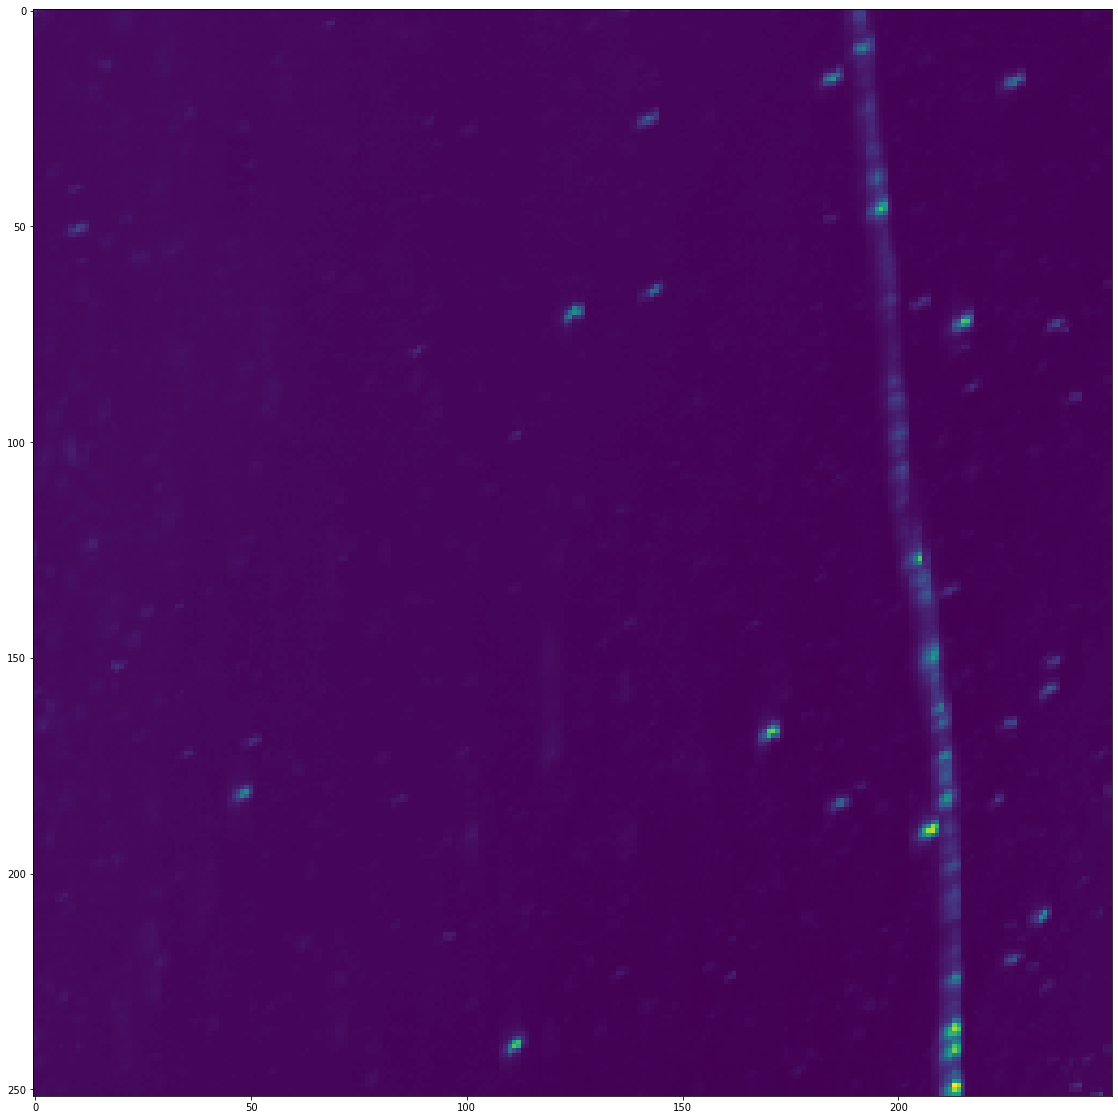

In [26]:
plt.figure(figsize=(20,20))
plt.imshow(im244.max(0))

In [30]:
pred244 = segmentCube(im244, network)

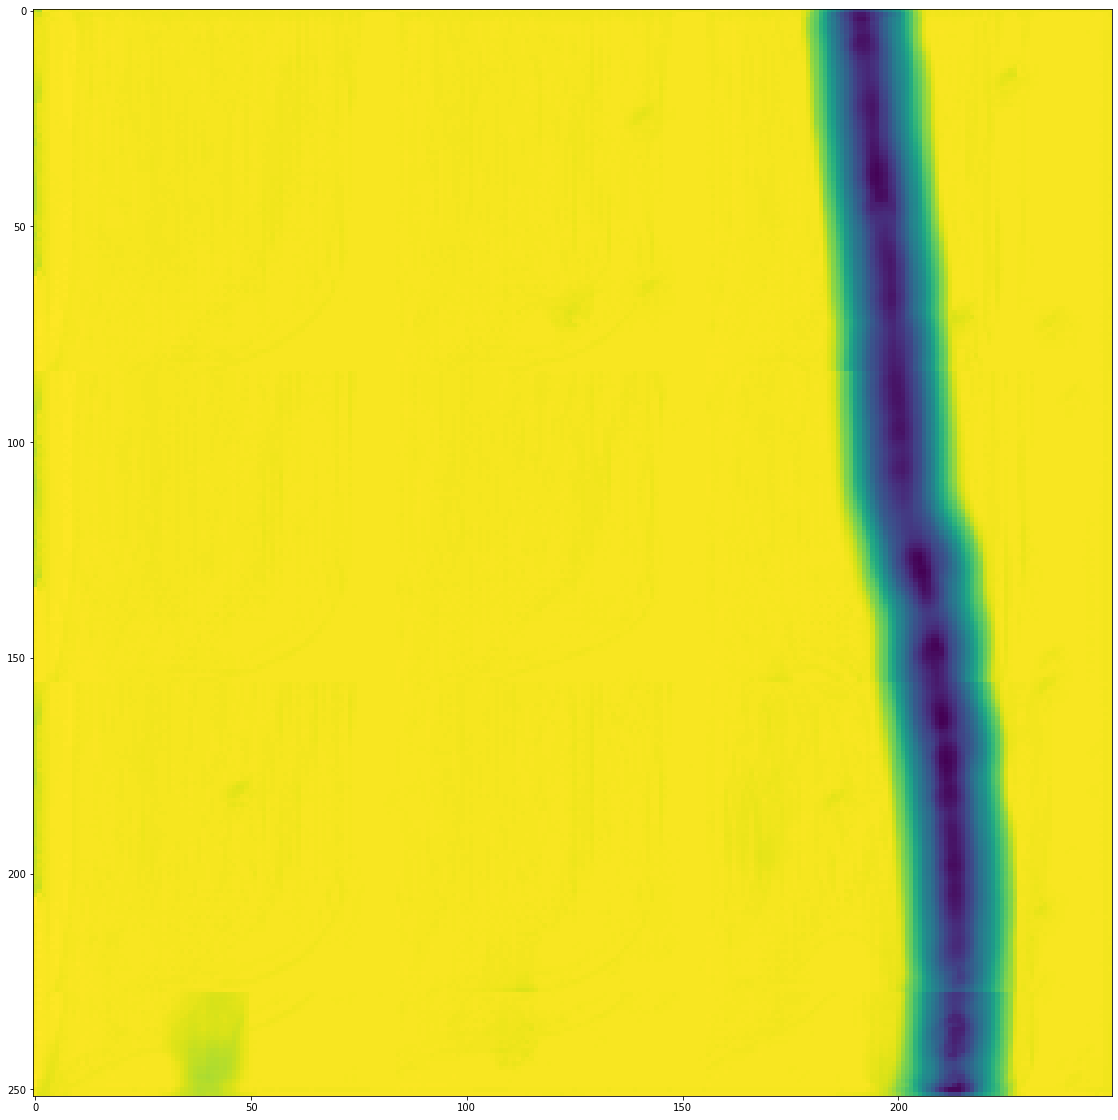

In [32]:
plt.figure(figsize=(20,20))
plt.imshow(pred244.min(0))

### Visualize pred

In [32]:
np.save("./im244.npy", ims)
np.save("./pred244.npy", preds)

In [33]:
ims = np.load("./im244.npy")
preds = np.load("./pred244.npy")

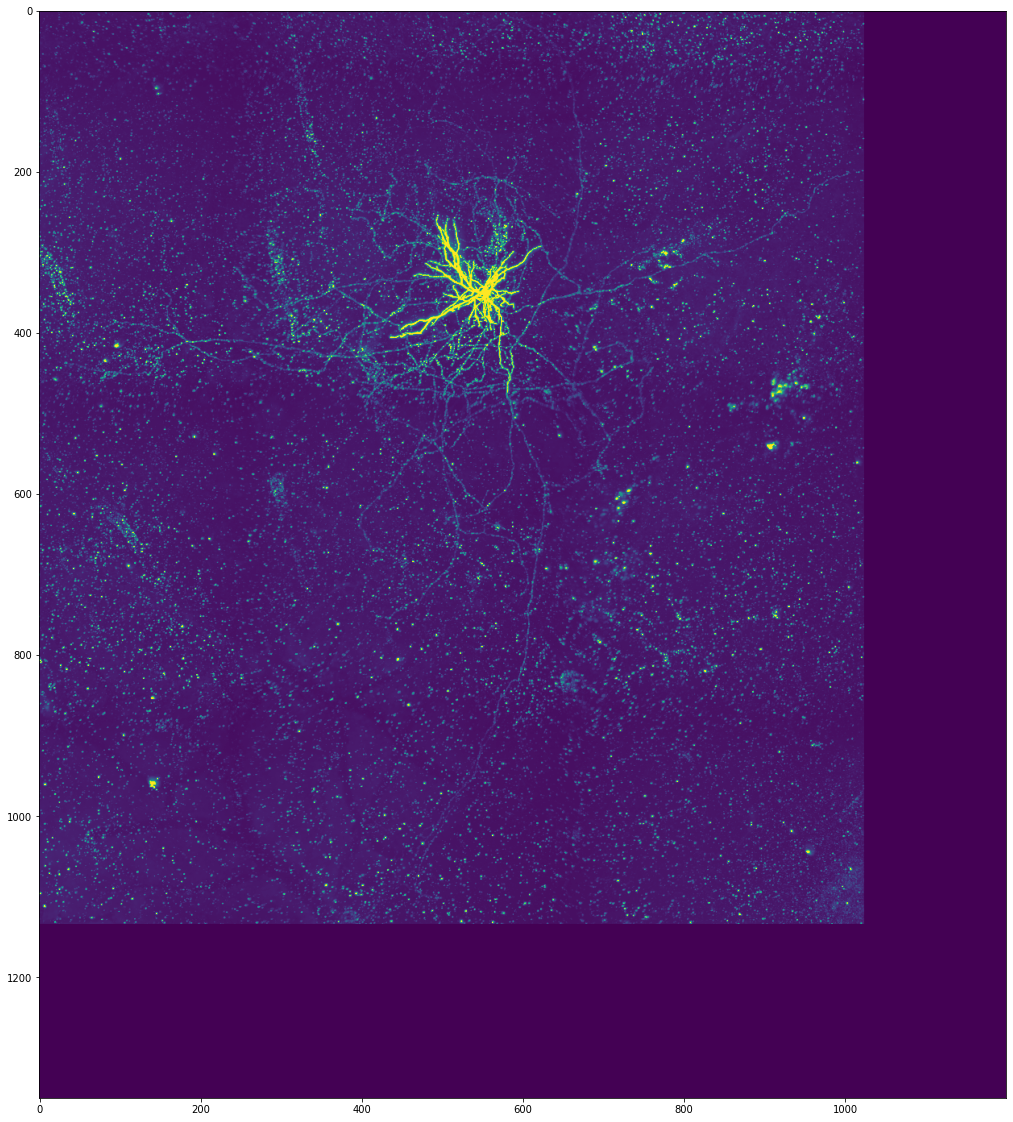

In [34]:
plt.figure(figsize=(20,20))
plt.imshow(ims.max(0))

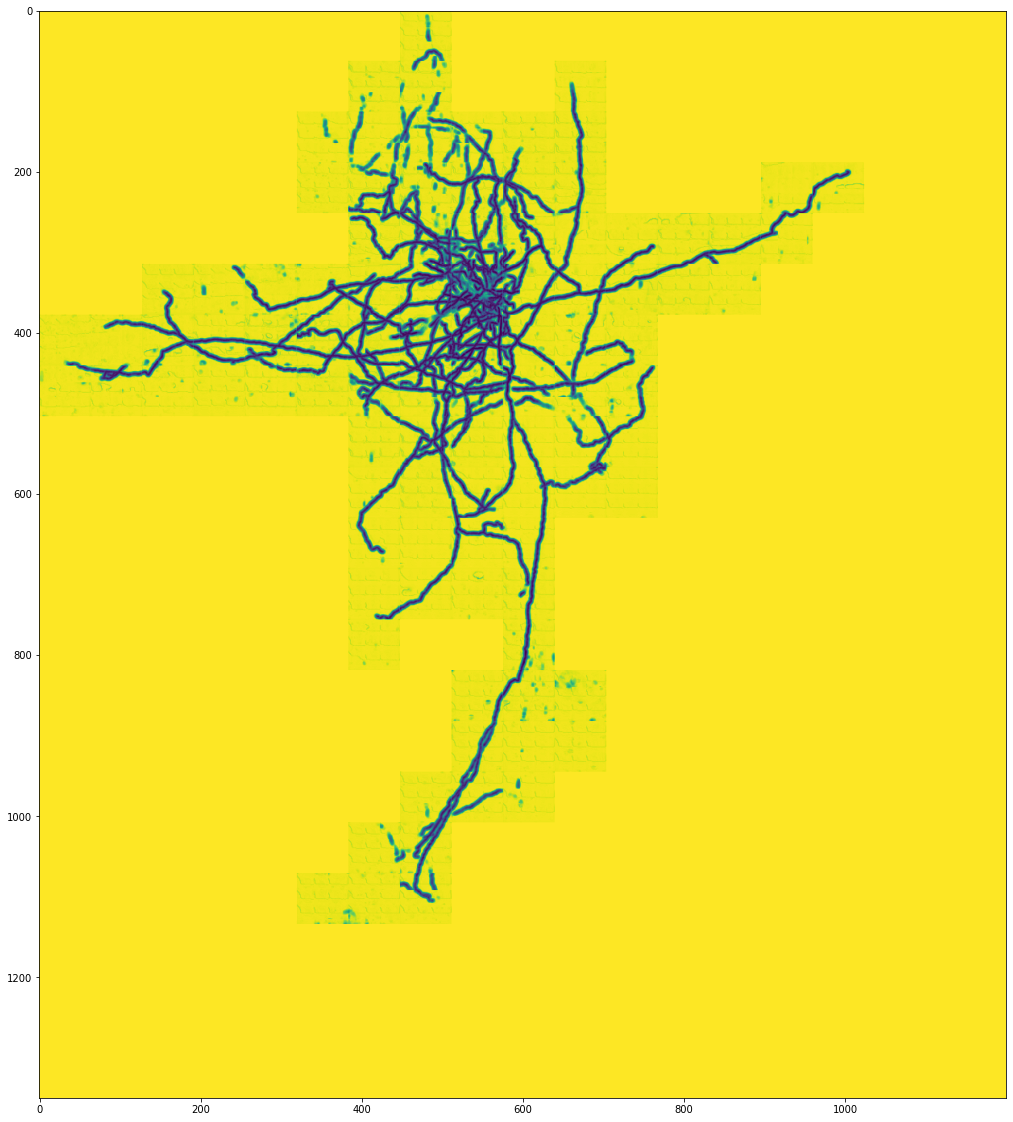

In [35]:
plt.figure(figsize=(20,20))
plt.imshow(preds.min(0))

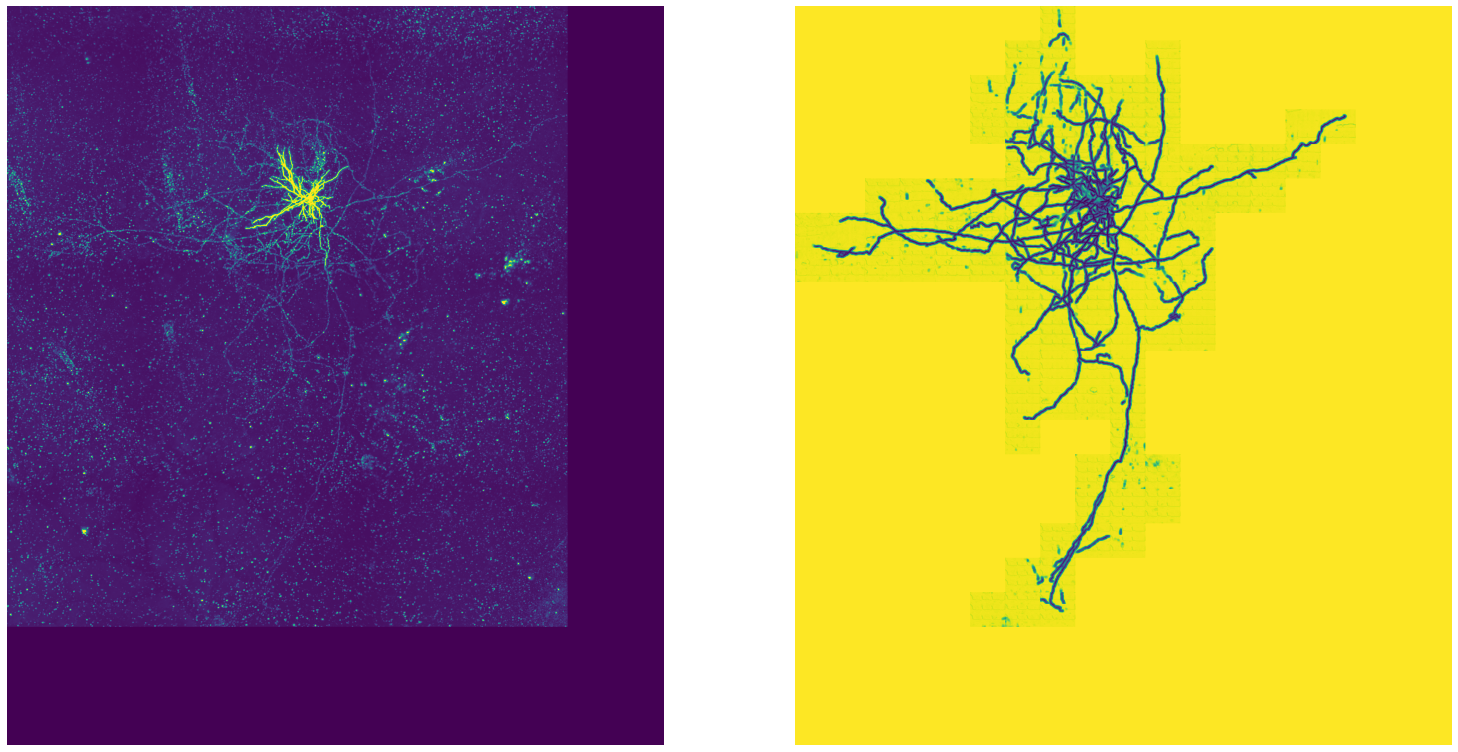

In [36]:
tmp = []
tmp.append(ims.max(0))
tmp.append(preds.min(0))

plt.figure(figsize=(40, 40))

for n, im in enumerate(tmp):
    # add a new subplot iteratively
    ax = plt.subplot(1, 3, n + 1)

    # filter df and plot ticker on the new subplot axis
    plt.imshow(im)

    # chart formattings
    plt.axis('off')